In [37]:
from pathlib import Path

import re

import numpy as np

import pandas as pd

import joblib

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    confusion_matrix,
)

import matplotlib.pyplot as plt

In [38]:
train = pd.read_csv("../data/train.csv")

In [39]:
train.head()

,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


In [40]:
x = np.array(train["textos"], dtype=np.dtypes.StringDType())

In [41]:
y = np.array(train["labels"], dtype=np.uint8)

In [42]:
# NLTK_DATA env var

nltk.download("punkt_tab")
nltk.download("stopwords")

spanish_stopwords = set(stopwords.words("spanish"))
print(f"📚 Spanish stopwords loaded: {len(spanish_stopwords)} words")

📚 Spanish stopwords loaded: 313 words


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/orpheezt/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/orpheezt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
SPECIAL_CHARS_PATTERN = re.compile(r"[^\w\s]")
MULTIPLE_SPACES_PATTERN = re.compile(r"\s+")


def clean_text(x: np.ndarray) -> np.ndarray:
    def clean_single_text(text: str) -> str:
        text = text.lower().strip("\"'")
        text = SPECIAL_CHARS_PATTERN.sub(" ", text)
        text = MULTIPLE_SPACES_PATTERN.sub(" ", text)

        if not text:
            return ""

        tokens = word_tokenize(text, language="spanish")
        tokens = [
            token
            for token in tokens
            if token not in spanish_stopwords and len(token) > 2
        ]
        return " ".join(tokens)

    vclean = np.vectorize(clean_single_text)
    return vclean(x)

In [44]:
print(f"📊 Data shape: x={x.shape}, Y={y.shape}")
print(f"📊 Classes in Y: {np.unique(y)}")

x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)

print("✅ Data split completed:")
print(f"   • Training: {x_train.shape[0]} samples")
print(f"   • Validation: {x_val.shape[0]} samples")
print(f"   • Classes distribution: {np.bincount(y_train)}")

📊 Data shape: x=(2424,), Y=(2424,)
📊 Classes in Y: [1 3 4]
✅ Data split completed:
   • Training: 1939 samples
   • Validation: 485 samples
   • Classes distribution: [  0 404   0 715 820]


In [45]:
m = Pipeline(
    [
        ("text_cleaner", FunctionTransformer(clean_text)),
        (
            "tfidf_vectorizer",
            TfidfVectorizer(
                max_features=5000,
                ngram_range=(1, 2),  # Use unigrams and bigrams
                min_df=2,  # Words that appear at least 2 times
                max_df=0.95,  # Exclude very common words
                strip_accents="unicode",  # Normalize accents
            ),
        ),
        (
            "svm_classifier",
            SVC(
                kernel="linear",
                C=1.0,
                random_state=42,
                probability=True,  # To get probabilities
            ),
        ),
    ]
)

In [46]:
m.fit(x_train, y_train)

print("\n📊 Evaluating pipeline performance...")
y_pred = m.predict(x_val)
accuracy = accuracy_score(y_val, y_pred)
f1_macro = f1_score(y_val, y_pred, average="macro")
f1_micro = f1_score(y_val, y_pred, average="micro")

print("🎯 Validation Results:")
print(f"   • Accuracy: {accuracy:.4f}")
print(f"   • F1-Score (Macro): {f1_macro:.4f}")
print(f"   • F1-Score (Micro): {f1_micro:.4f}")

print("\n📋 Detailed Classification Report:")
print("=" * 60)
report = classification_report(y_val, y_pred, target_names=["ODS 1", "ODS 3", "ODS 4"])
print(report)


📊 Evaluating pipeline performance...
🎯 Validation Results:
   • Accuracy: 0.9588
   • F1-Score (Macro): 0.9561
   • F1-Score (Micro): 0.9588

📋 Detailed Classification Report:
              precision    recall  f1-score   support

       ODS 1       0.96      0.93      0.94       101
       ODS 3       0.95      0.96      0.95       179
       ODS 4       0.97      0.98      0.97       205

    accuracy                           0.96       485
   macro avg       0.96      0.95      0.96       485
weighted avg       0.96      0.96      0.96       485




🎯 Confusion Matrix:


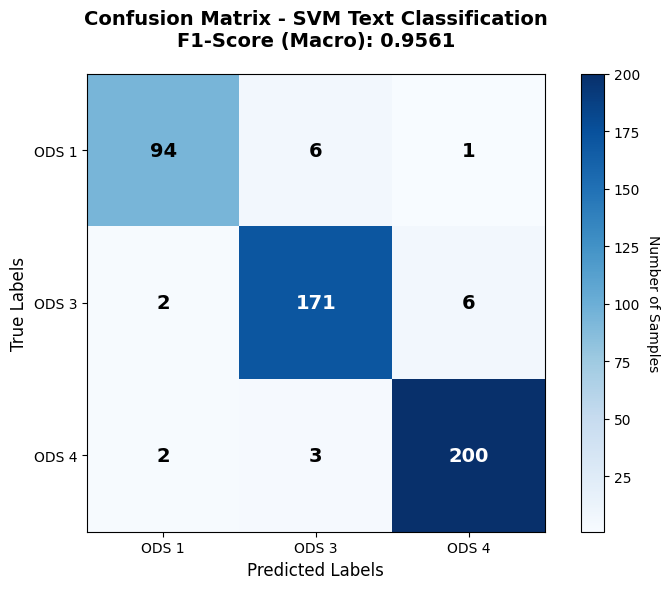


📊 Confusion Matrix Analysis:
   • Total predictions: 485
   • Correct predictions: 465 (95.9%)
   • Misclassifications: 20 (4.1%)
   • ODS 1 → ODS 3: 6 samples
   • ODS 1 → ODS 4: 1 samples
   • ODS 3 → ODS 1: 2 samples
   • ODS 3 → ODS 4: 6 samples
   • ODS 4 → ODS 1: 2 samples
   • ODS 4 → ODS 3: 3 samples


In [47]:
print("\n🎯 Confusion Matrix:")
print("=" * 40)

cm = confusion_matrix(y_val, y_pred)
class_names = ["ODS 1", "ODS 3", "ODS 4"]

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation="nearest", cmap="Blues")

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Number of Samples", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

thresh = cm.max() / 2.0
for i in range(len(class_names)):
    for j in range(len(class_names)):
        ax.text(
            j,
            i,
            format(cm[i, j], "d"),
            ha="center",
            va="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=14,
            fontweight="bold",
        )

ax.set_title(
    "Confusion Matrix - SVM Text Classification\nF1-Score (Macro): 0.9561",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
ax.set_xlabel("Predicted Labels", fontsize=12)
ax.set_ylabel("True Labels", fontsize=12)

plt.tight_layout()
plt.show()

print("\n📊 Confusion Matrix Analysis:")
print(f"   • Total predictions: {cm.sum()}")
print(
    f"   • Correct predictions: {np.trace(cm)} ({np.trace(cm) / cm.sum() * 100:.1f}%)"
)
print(
    f"   • Misclassifications: {cm.sum() - np.trace(cm)} ({(cm.sum() - np.trace(cm)) / cm.sum() * 100:.1f}%)"
)

for i, true_class in enumerate(class_names):
    for j, pred_class in enumerate(class_names):
        if i != j and cm[i, j] > 0:
            print(f"   • {true_class} → {pred_class}: {cm[i, j]} samples")

In [48]:
MODELS_DIR = Path("../data/saved_models")
MODELS_DIR.mkdir(exist_ok=True)

pipeline_path = MODELS_DIR / "best_pipeline_svm.joblib"
joblib.dump(m, pipeline_path)

print("💾 Pipeline serialized successfully!")
print(f"   📁 Saved to: {pipeline_path.resolve()}")
print("   📊 Model type: SVM with preprocessing pipeline")
print(f"   🎯 Performance: {f1_macro:.4f} F1-Score (Macro)")

print("\n🔍 Verifying saved pipeline...")
loaded_pipeline = joblib.load(pipeline_path)

match loaded_pipeline:
    case Pipeline():
        print("✅ Pipeline loaded and verified as sklearn Pipeline!")

        test_texts = np.array(
            [
                "Los niños necesitan acceso a educación de calidad",  # Should be ODS 4 (Education)
                "Es importante reducir la pobreza en las comunidades rurales",  # Should be ODS 1 (Poverty)
                "Los servicios de salud deben ser accesibles para todos",  # Should be ODS 3 (Health)
            ],
            dtype=np.dtypes.StringDType(),
        )

        test_predictions = loaded_pipeline.predict(test_texts)
        test_probabilities = loaded_pipeline.predict_proba(test_texts)

        print("\n🧪 Sample predictions:")
        for i, (text, pred, probs) in enumerate(
            zip(test_texts, test_predictions, test_probabilities)
        ):
            print(f"   Text {i + 1}: ODS {pred} (confidence: {max(probs):.3f})")

        print("\n📋 Pipeline components:")
        for i, (name, component) in enumerate(loaded_pipeline.named_steps.items()):
            print(f"   {i + 1}. {name}: {type(component).__name__}")
    case _:
        print("❌ Error: Loaded object is not a sklearn Pipeline!")
        print(f"   Type found: {type(loaded_pipeline)}")

💾 Pipeline serialized successfully!
   📁 Saved to: /home/orpheezt/university/proyecto1/data/saved_models/best_pipeline_svm.joblib
   📊 Model type: SVM with preprocessing pipeline
   🎯 Performance: 0.9561 F1-Score (Macro)

🔍 Verifying saved pipeline...
✅ Pipeline loaded and verified as sklearn Pipeline!

🧪 Sample predictions:
   Text 1: ODS 4 (confidence: 1.000)
   Text 2: ODS 1 (confidence: 1.000)
   Text 3: ODS 3 (confidence: 1.000)

📋 Pipeline components:
   1. text_cleaner: FunctionTransformer
   2. tfidf_vectorizer: TfidfVectorizer
   3. svm_classifier: SVC
